In this task, you are going to cluster MNIST dataset using a pretrained ResNet 18 model and k-means.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from PIL import Image
from sklearn.metrics import accuracy_score

c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset

Load the MNIST dataset bellow. You can use either `torchvision.datasets.MNIST` or `sklearn.datasets.fetch_openml()` or any other way to load the dataset. Note that you won't need a validation set.

In [2]:
mnist_train = torchvision.datasets.MNIST(root='data/', train=True, transform=T.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(root='data/', train=False, transform=T.ToTensor(), download=True)

# Normalize mnist dataset 
mean = mnist_train.data.float().mean()/255
std = mnist_train.data.float().std()/255

# Define the transform
transformer = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Resize((32,32)),
    T.Normalize(mean=mean, std=std),
])

mnist_train = torchvision.datasets.MNIST(root='data/', train=True, transform=transformer, download=True)
mnist_test = torchvision.datasets.MNIST(root='data/', train=False, transform=transformer, download=True)

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=1024, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=1024, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

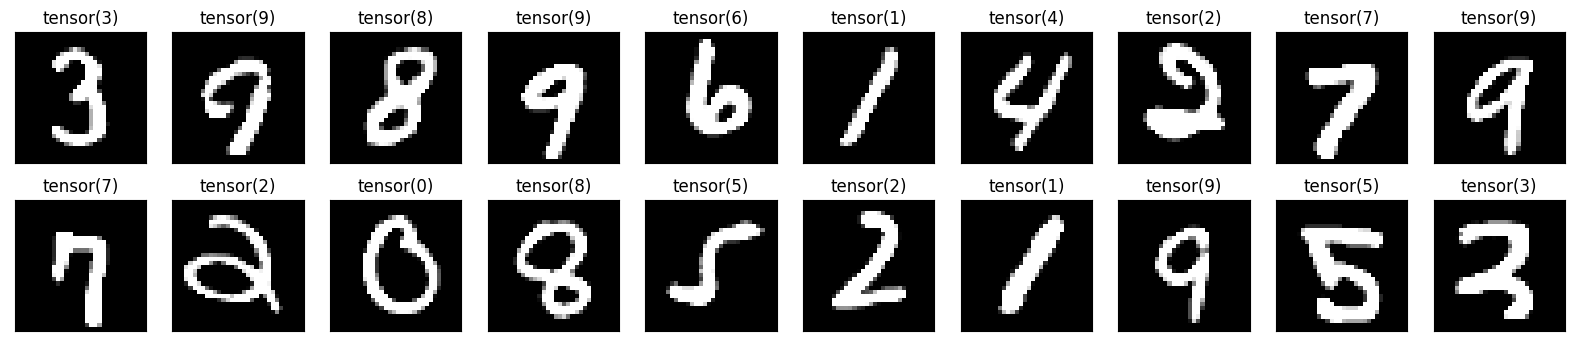

In [3]:
def plot_samples(x,y, n=20):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2,10, i + 1)
        plt.imshow(x[i].permute(1,2,0))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title(y[i])
    plt.show()

# Plot some samples
x, y = next(iter(trainloader))
plot_samples(x, y)

# Get ResNet 18

Instantiate ResNet 18 model (pretrained on imagenet) from `torchvision`'s model zoo.

In [4]:
def create_resnet18_model():
    model = torchvision.models.resnet18(pretrained=True)
    return model

model = create_resnet18_model()
model

c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Remove the decider layer

Replace the `fc` layer of the resnet with an `Identity` layer so that we use the hidden features of the last layer.

In [5]:
def make_no_grad(module):
    for param in module.parameters():
        param.requires_grad = False
        
def make_trainable(module):
    for param in module.parameters():
        param.requires_grad = True

def change_model(model):
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Identity()
    for m in model.children():
        make_no_grad(m)
        
    
    return model
    
model = change_model(model).cuda()
x = torch.randn(10,3,32,32)
x = x.cuda()
z: np.ndarray = model(x).cpu().numpy()
z.shape

(10, 512)

# Cluster the data

Use `MiniBatchKMeans` to cluster the MNIST dataset in 64 clusters.

In [6]:
kmeans = MiniBatchKMeans(
    n_clusters=64,
    batch_size=1024,
    verbose=1,
    random_state=42,                         
)

In [7]:
from tqdm import tqdm


def extract_features(model,dataloader):
    with torch.no_grad():
        model.eval()
        features = []
        labels = []
        for x,y in tqdm(dataloader):
            x = x.cuda()
            z: np.ndarray = model(x).cuda().cpu().numpy()
            kmeans.partial_fit(z)
            features.append(z)
            labels.append(y)
        
        features = np.concatenate(features)
        labels = np.concatenate(labels)
    return features, labels


features , labels = extract_features(model, trainloader)

100%|██████████| 59/59 [00:25<00:00,  2.30it/s]


In [9]:
# visualize result of kmeans

def plot_kmeans_result(kmeans, x, y):
    plt.figure(figsize=(10, 10))
    # determine labels with corrospoding cluster
    labels = np.zeros_like(kmeans.labels_)
     
    plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(kmeans.cluster_centers_[:, 0] ,kmeans.cluster_centers_[:, 1], color='black')
    plt.title("Kmeans result")
    plt.show()

# Assign clusters to test set.

Predict cluster for test set samples.

In [10]:
truthAmounts = []
predictions = []
with torch.no_grad():
    model.eval()
    for x, y in tqdm(testloader, total=len(testloader)):
        x: torch.Tensor = x.cuda()
        z: np.ndarray = model(x).cpu().numpy()
        truthAmounts.append(y.numpy())
        predictions.append(kmeans.predict(z))
ground_truth = np.concatenate(truthAmounts)
predictions = np.concatenate(predictions)

100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


# Draw clusters

Draw 10 random samples per each cluster from the test set.

In [11]:
from multiprocessing import Pool, cpu_count

image_per_cluster = 5


def select_images(cluster: int):
    indices = np.argwhere(predictions == cluster)[:, 0]
    chosen = np.random.choice(indices, size=image_per_cluster, replace=False)
    labels = ground_truth[chosen]
    images = [mnist_test[i][0][0].numpy() for i in chosen]
    return images, labels

# select images for each cluster
clusters = []
for i in range(10):
    images, labels = select_images(i)
    clusters.append((images, labels))


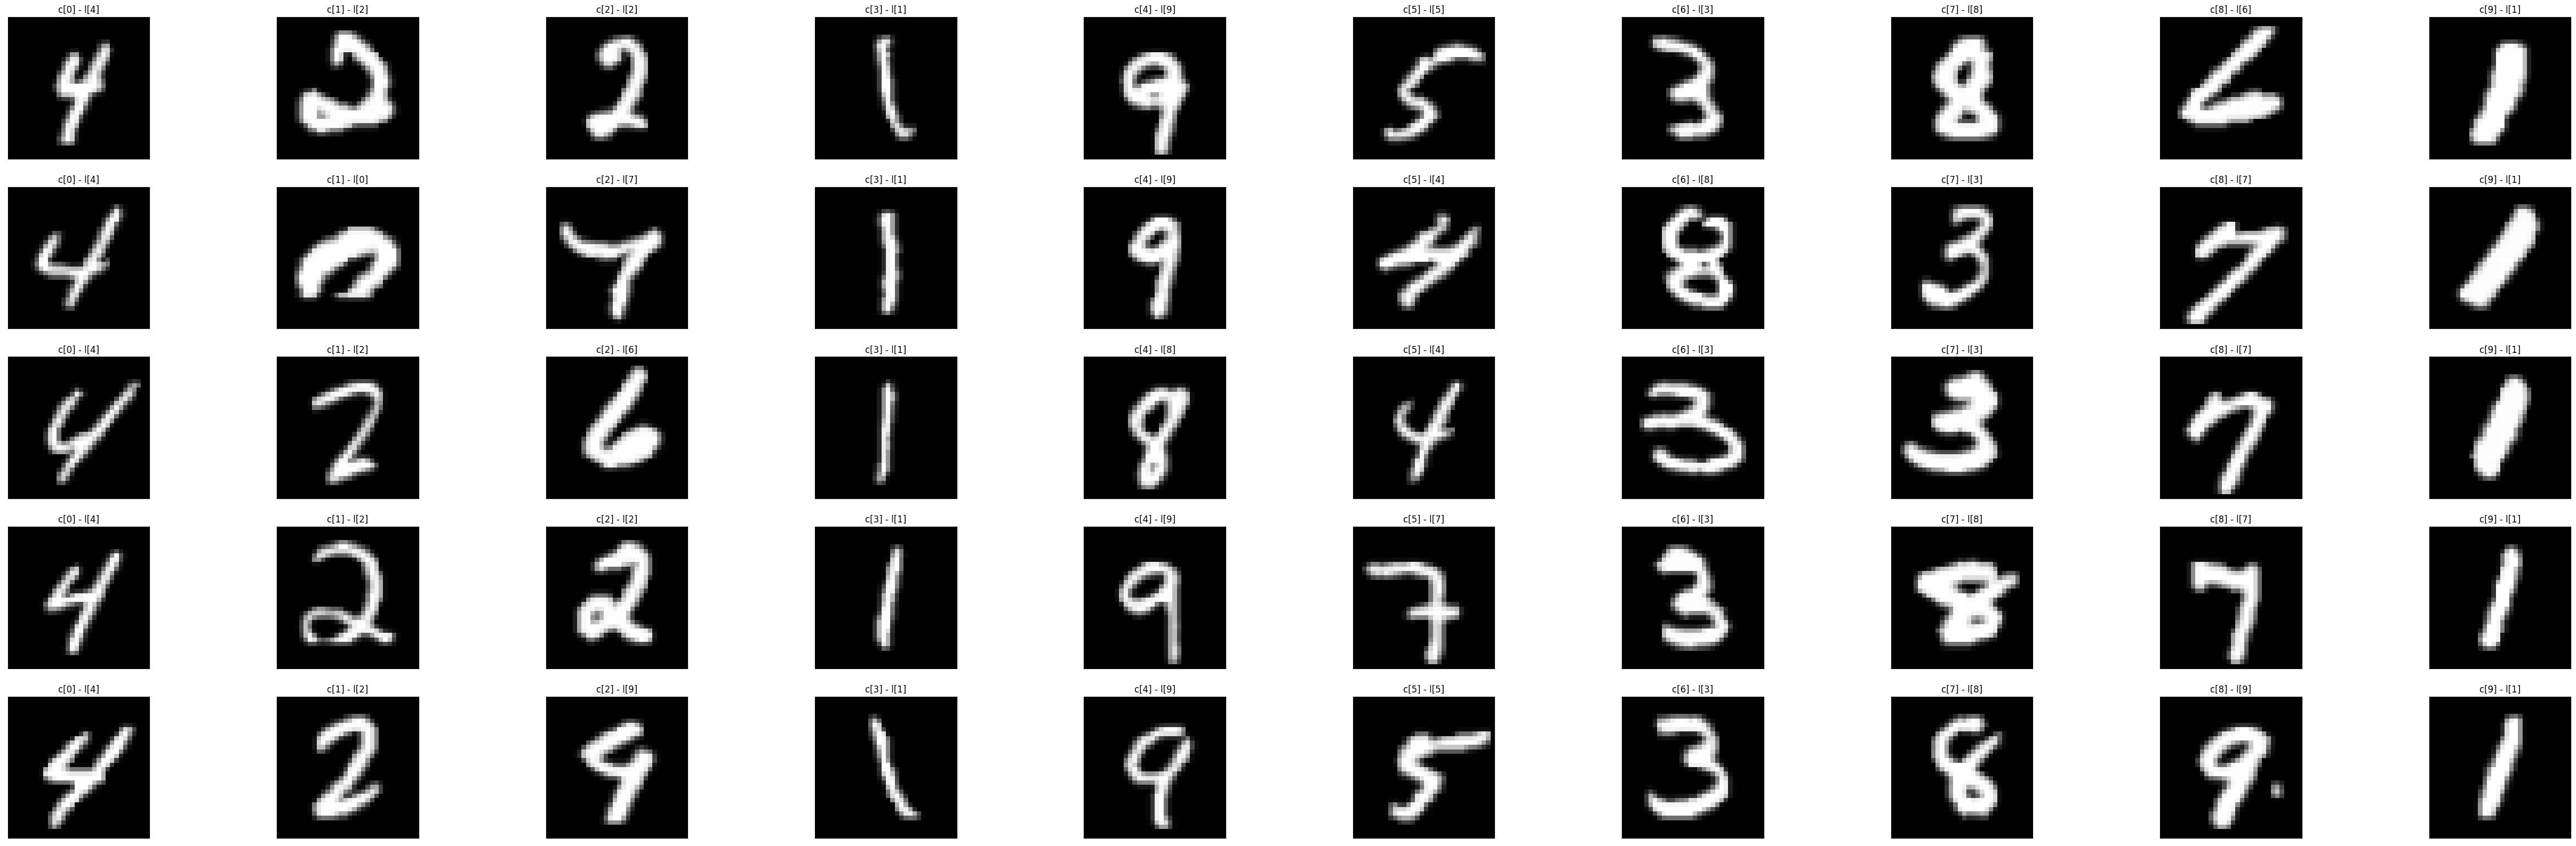

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(64, 20))
for ir, row in enumerate(axes):
    for cluster, ax in enumerate(row):
        image = clusters[cluster][0][ir]
        image = (image - image.min()) / (image.max() - image.min())
        label = clusters[cluster][1][ir]
        ax.set_title(f'c[{cluster}] - l[{label}]')
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(image, cmap='gray')
plt.show()